In [ ]:
!pip install timm
!pip install -U albumentations

     |████████████████████████████████| 244 kB 863 kB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 72 kB 367 kB/s eta 0:00:01
     |████████████████████████████████| 71 kB 156 kB/s eta 0:00:01


In [ ]:
# !git clone https://github.com/NVIDIA/apex
# %cd apex
# !pip install -v --disable-pip-version-check --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./
# %cd ..

In [ ]:
# Essentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import copy
import sys
from datetime import datetime
import random
from tqdm import tqdm_notebook as tqdm
from PIL import Image
import cv2
# Sklearn
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
# Torch
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
# TorchVision
from torchvision import models, transforms, datasets
from torchvision.utils import make_grid
# Timm
import timm
# Nividia Apex
# from apex import amp
# Albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

device = torch.device('cuda')

In [ ]:
!nvidia-smi

# ⚠️Seed everything!
It's important to seed everything for reproducibility.

In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
seed = 42
seed_everything(seed)

# EDA

In [ ]:
df_train = pd.read_csv('../input/3md3070-dlmi/trainset/trainset_true.csv')
df_train['GENDER'] = df_train.GENDER.apply(lambda x: int(x=='F'))
df_train['DOB'] = df_train['DOB'].apply(lambda x: x.replace("-", "/"))
df_train['AGE'] = df_train['DOB'].apply(lambda x: 2020-int(x.split("/")[-1]))

In [ ]:
sns.pairplot(df_train[['LABEL', 'GENDER', 'LYMPH_COUNT', "AGE"]])

In [ ]:
df_test = pd.read_csv('../input/3md3070-dlmi/testset/testset_data.csv')
df_test['GENDER'] = df_test.GENDER.apply(lambda x: int(x=='F'))
df_test['DOB'] = df_test['DOB'].apply(lambda x: x.replace("-", "/"))
df_test['AGE'] = df_test['DOB'].apply(lambda x: 2020-int(x.split("/")[-1]))
df_test.head()

In [ ]:
df_train.LABEL.hist()
plt.show()

In [ ]:
def show_sample(group, shape=(5,2), figsize=(15,15)):
    total_samples = shape[0]*shape[1]
    nrow = shape[0]
    
    path_samples = random.sample(os.listdir(f'../input/3md3070-dlmi/trainset/{group}'),total_samples)
    batch_tensor = []
    for path in path_samples:
        img = transforms.ToTensor()(Image.open(os.path.join(f'../input/3md3070-dlmi/trainset/{group}', path)).convert("RGB")).unsqueeze(0)
        batch_tensor.append(img)
    batch_tensor = torch.cat(batch_tensor)
    grid_img = make_grid(batch_tensor, nrow=nrow)
    plt.figure(figsize=figsize)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()

In [ ]:
print("Showing 10 samples from P190")
show_sample("P190")

# DataLoading

In [ ]:
class LymphBags(torch.utils.data.Dataset):
    def __init__(self, bags_dir, df, indices, mode='train', transforms=None):
        assert mode in ['train', 'test'], "mode must belong to ['train', 'test']"
        self.transforms = transforms
        self.mode = mode
        self.df = df
        self.dir = bags_dir
        self.bags = list(filter(lambda x: x[0] == 'P', os.listdir(bags_dir)))
        self.bags = [self.bags[i] for i in indices]
        
    def __len__(self):
        return len(self.bags)
        
    def __getitem__(self, index):
        
        idx_ = self.df[self.df.ID == self.bags[index]].index[0]
        gender, count, age = self.df.iloc[idx_ , [2,4,5]]
        bags = os.path.join(self.dir, self.bags[index])
        images = []
        for bag in os.listdir(bags):
            img = cv2.imread(os.path.join(bags, bag))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            if self.transforms:
                img = self.transforms(image=img)['image'].unsqueeze(0)
            images.append(img)
            
        if self.mode == 'train':
            label = self.df.iloc[idx_, 1]
            return torch.cat(images), gender, count, age, label
        else:
            return torch.cat(images), gender, count, age, idx_


In [ ]:
def train_val_dataset(df, bags_dir, train_transforms=None, val_transforms=None, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(df))), test_size=val_split, stratify = df.LABEL.values)
    train_set = LymphBags(bags_dir, df, indices = train_idx, transforms=train_transforms)
    val_set = LymphBags(bags_dir, df, indices = val_idx, transforms=val_transforms)
    return train_set, val_set

# CNN Baseline

We will be using a model from the paper ["Attention-based Deep Multiple Instance Learning"](https://arxiv.org/pdf/1802.04712v4.pdf)

In [ ]:
class BaseLineCNN(nn.Module):
    def __init__(self, head, D=512, mode='average'):
        super(BaseLineCNN, self).__init__()
        assert mode in ['average', 'max', 'min']

        self.feature_extractor = head
        self.mode = mode
        self.D = D
    
        self.classifier = nn.Sequential(
            nn.Linear(self.D, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256,1),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        x = x.squeeze(0)

        H = self.feature_extractor(x) # NxL
        if self.mode == 'average':
            H = torch.mean(H, dim=0)

        Y_prob = self.classifier(H.unsqueeze(0))
        Y_prob = torch.log(1e-10 + torch.cat([Y_prob, 1-Y_prob], dim=1))
        Y_hat = torch.argmax(Y_prob)
        return Y_prob, Y_hat

In [ ]:
class Attention(nn.Module):
    def __init__(self, head, L=500, D=64, K=1):
        super(Attention, self).__init__()
        self.L = L
        self.D = D
        self.K = K

        self.feature_extractor = head

        self.attention = nn.Sequential(
            nn.Linear(self.L, self.D),
            nn.Tanh(),
            nn.Dropout(0.4),
            nn.Linear(self.D, self.K)
        )

        self.classifier = nn.Sequential(
            nn.Linear(self.L*self.K+64*3, 1),
            nn.Sigmoid(),
        )
        
        self.age_embed = nn.Sequential(
            nn.Linear(1,64),
            nn.ReLU(),
            nn.Dropout(0.2))
        self.gender_embed = nn.Sequential(
            nn.Linear(1,64),
            nn.ReLU(),
            nn.Dropout(0.2))
        self.count_embed = nn.Sequential(
            nn.Linear(1,64),
            nn.ReLU(),
            nn.Dropout(0.2))
        
    def forward(self, x, gender, count, age):
        x = x.squeeze(0)

        H = self.feature_extractor(x) # NxL
         
        age_feat = self.age_embed(age) # Age featurizer
        gender_feat = self.gender_embed(gender) # Gender featurizer
        count_feat = self.count_embed(count) # Lymph count featurizer
        A = self.attention(H)  # NxK
        A = torch.transpose(A, 1, 0)  # KxN
        A = F.softmax(A, dim=1)  # softmax over N
        M = torch.mm(A, H)  # KxL
        M = M.view(-1)
        M = torch.cat([M, age_feat.squeeze(), gender_feat.squeeze(), count_feat.squeeze()], dim=0).unsqueeze(0)
        Y_prob = self.classifier(M)
        Y_prob = torch.log(1e-10 + torch.cat([Y_prob, 1-Y_prob], dim=1))
        Y_hat = torch.argmax(Y_prob)
        return Y_prob, Y_hat

Here we define the training function:

In [ ]:
def train(epoch, batch_size=2):
    # Useful for batch size
    counter = {"train": 0, "val": 0}
    nb_batches = {"train": 0, "val": 0}
    # Tracking
    train_loss = 0.
    train_balanced = 0.
    
    model.train()
    y_true = []
    y_pred = []
    batch_y_prob = {"train": [], "val": []}
    batch_label = {"train": [], "val": []}
    
    for batch_idx, (data, gender, count, age, bag_label) in enumerate(train_loader):
        data, gender, count, age = data.to(device), gender.to(device).float(), count.to(device).float(), age.to(device).float()
        #data = data.to(device)
        # calculate loss and metrics
        Y_prob, Y_hat = model(data, gender, count, age)
        #Y_prob, Y_hat = model(data)
        batch_y_prob['train'].append(Y_prob)
        batch_label['train'].append(bag_label)
        
        y_true.append(bag_label[0])
        y_pred.append(Y_hat.squeeze(0).detach().item())
        counter['train'] += 1
        if (counter['train'] == batch_size) or (batch_idx == len(train_loader)-1):
            batch_y_prob['train'] = torch.cat(batch_y_prob['train'], dim = 0)
            batch_label['train'] = torch.cat(batch_label['train'], dim = 0)
            loss = criterion(batch_y_prob['train'], batch_label['train'].to(device))
            train_loss += loss.item()
            train_balanced += balanced_accuracy_score(y_true, y_pred)
        
            # reset gradients
            optimizer.zero_grad()
#             with amp.scale_loss(loss, optimizer) as scaled_loss:
            loss.backward()
            optimizer.step()
            
            # reset everything
            nb_batches['train'] += 1
            counter["train"] = 0
            y_true = []
            y_pred = []

            batch_y_prob['train'] = []
            batch_label['train'] = []        
    model.eval()
    
    # Useful for batch size
    val_counter = 0 
    val_nb_batches = 0
    # Tracking
    val_loss = 0.
    val_balanced = 0.
    
    y_true = []
    y_pred = []
    for batch_idx, (data, gender, count, age, bag_label) in enumerate(val_loader):
        data, gender, count, age = data.to(device), gender.to(device).float(), count.to(device).float(), age.to(device).float()
        #data = data.to(device)
        #print(data.shape, gender.shape, count.shape, age.shape)
        # calculate loss and metrics
        with torch.no_grad():
            Y_prob, Y_hat = model(data, gender, count, age)
            #Y_prob, Y_hat = model(data)
            batch_y_prob['val'].append(Y_prob)
            batch_label['val'].append(bag_label)

            y_true.append(bag_label[0])
            y_pred.append(Y_hat.squeeze(0).detach().item())
            counter['val'] += 1
            
            if (counter['val'] == batch_size) or (batch_idx == len(val_loader)-1):
                batch_y_prob['val'] = torch.cat(batch_y_prob['val'], dim = 0)
                batch_label['val'] = torch.cat(batch_label['val'], dim = 0)

                loss = criterion(batch_y_prob['val'], batch_label['val'].to(device))
                val_loss += loss.item()
                val_balanced += balanced_accuracy_score(y_true, y_pred)
                # reset everything
                nb_batches['val'] += 1
                counter["val"] = 0
                y_true = []
                y_pred = []
                batch_y_prob['val'] = []
                batch_label['val'] = []
    
    train_balanced /= nb_batches['train']
    val_balanced /= nb_batches['val']
    print(nb_batches)
    if val_balanced > val_best:
        best_model = copy.deepcopy(model.state_dict())
    # calculate loss and error for epoch
    train_loss /= len(train_loader)
    
    val_loss /= len(val_loader)
    
    loss_history['train'].append(train_loss)
    loss_history['val'].append(val_loss)
    print('Epoch: {}, Train Loss: {:.4f}, Train Balanced Accuracy: {:.4f}'.format(epoch, train_loss, train_balanced))
    print('Epoch: {}, Val Loss: {:.4f}, Val Balanced Accuracy: {:.4f}'.format(epoch, val_loss, val_balanced))
    scheduler.step()
    return best_model

In [ ]:
train_dir = '../input/3md3070-dlmi/trainset'
test_dir = '../input/3md3070-dlmi/testset'

# Data Augmentation
train_tsfms = A.Compose(
    [
        A.Resize(150,150),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Flip(p=0.25),
        A.FancyPCA(p=0.5),
        #A.Blur(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ]
)

val_tsfms = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])
trainset, valset = train_val_dataset(df_train, train_dir, train_transforms=train_tsfms, val_transforms=val_tsfms, val_split=0.25)
print("There are", len(trainset), "bags in the training set")
print("There are", len(valset), "bags in the training set")
train_loader = DataLoader(trainset,batch_size=1, shuffle=True, pin_memory=True, num_workers=4)
val_loader = DataLoader(valset,batch_size=1, shuffle=True, pin_memory=True, num_workers=4)

In [ ]:
bags_, gender_, count_, age_, label_ = trainset[20]
print("Gender:", gender_, "Count:", count_, "Age:", age_, "Label:", label_)
example = bags_[15]
example[0] = (example[0]*0.229+0.485)
example[1] = (example[1]*0.224+0.456)
example[2] = (example[2]*0.225+0.406)
plt.imshow(example.permute(1,2,0).numpy())
plt.show()

In [ ]:
bags, gender, count, age, bag_label = valset[1]
print(gender, count, age, bag_label)
example = bags[15]
example[0] = (example[0]*0.229+0.485)
example[1] = (example[1]*0.224+0.456)
example[2] = (example[2]*0.225+0.406)
plt.imshow(example.permute(1,2,0).numpy())
plt.show()

In [32]:
feat_extractor = timm.create_model('resnet18', pretrained=False, num_classes=0)
feat_extractor.train()
print('')

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [36]:
# Define model
model = Attention(head=feat_extractor, L=512)
model = model.to(device)
#model.load_state_dict(torch.load('../input/resnet1850epochs-dlmi/resnet18-50epochs.pth'))
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)
# model, optimizer = amp.initialize(model, optimizer, opt_level="O2")
criterion = nn.NLLLoss()
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.97)

In [34]:
# Define model
model = BaseLineCNN(head=feat_extractor, D=512)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
# model, optimizer = amp.initialize(model, optimizer, opt_level="O2")
criterion = nn.NLLLoss()
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.97)

In [37]:
loss_history = {'train': [], 'val': []}
val_best = 0
for epoch in tqdm(range(50)):
    best = train(epoch, 8)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/50 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


{'train': 16, 'val': 6}
Epoch: 0, Train Loss: 0.2275, Train Balanced Accuracy: 0.4295
Epoch: 0, Val Loss: 0.3167, Val Balanced Accuracy: 0.2643
{'train': 16, 'val': 6}
Epoch: 1, Train Loss: 0.1816, Train Balanced Accuracy: 0.4065
Epoch: 1, Val Loss: 0.2114, Val Balanced Accuracy: 0.4873
{'train': 16, 'val': 6}
Epoch: 2, Train Loss: 0.1580, Train Balanced Accuracy: 0.5734
Epoch: 2, Val Loss: 0.1974, Val Balanced Accuracy: 0.3107
{'train': 16, 'val': 6}
Epoch: 3, Train Loss: 0.1307, Train Balanced Accuracy: 0.6278
Epoch: 3, Val Loss: 0.1316, Val Balanced Accuracy: 0.4782
{'train': 16, 'val': 6}
Epoch: 4, Train Loss: 0.0969, Train Balanced Accuracy: 0.7019
Epoch: 4, Val Loss: 0.1114, Val Balanced Accuracy: 0.4964
{'train': 16, 'val': 6}
Epoch: 5, Train Loss: 0.0658, Train Balanced Accuracy: 0.7516
Epoch: 5, Val Loss: 0.1145, Val Balanced Accuracy: 0.5458
{'train': 16, 'val': 6}
Epoch: 6, Train Loss: 0.0577, Train Balanced Accuracy: 0.7693
Epoch: 6, Val Loss: 0.1912, Val Balanced Accuracy:

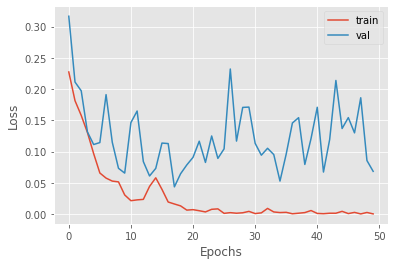

In [38]:
plt.style.use('ggplot')
plt.plot(loss_history['train'], label='train')
plt.plot(loss_history['val'], label='val')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.show()

# Prediction on validation set

We validate using our best weights from the training.

In [39]:
# Load best weights from training
model.load_state_dict(best)
#torch.save(model.state_dict(), "resnet18-250epochs.pth")
model.eval()
y_true = []
y_pred = []
for batch_idx, (data, gender, count, age, bag_label) in enumerate(tqdm(val_loader)):
    data, gender, count, age, bag_label = data.to(device), gender.to(device).float(), count.to(device).float(), age.to(device).float(), bag_label.float()
    # calculate loss and metrics
    with torch.no_grad():
        _, Y_hat = model(data, gender, count, age)
        y_true.append(bag_label[0])
        y_pred.append(Y_hat.squeeze(0).detach().item())
val_balanced = balanced_accuracy_score(y_true, y_pred)
print("Validation Accuracy",val_balanced)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/41 [00:00<?, ?it/s]

Validation Accuracy 0.5769230769230769


# Submission time
Time to send our predictions to the evaluation

In [26]:
sub_dict = {"ID":[], "Predicted": [], "idx": []}
testset = LymphBags(test_dir, df_test, indices=range(len(df_test)), mode='test', transforms=val_tsfms)
test_loader = DataLoader(testset,batch_size=1, shuffle=True)
model.eval()
for batch_idx, (data, gender, count, age, idx) in enumerate(tqdm(test_loader)):
    data, gender, count, age = data.to(device), gender.to(device).float(), count.to(device).float(), age.to(device).float()
    _, y_hat = model(data, gender, count, age)
    sub_dict["ID"].append(df_test.iloc[idx.item(),0])
    sub_dict['Predicted'].append(int(y_hat.item()))
    sub_dict['idx'].append(idx.item())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/42 [00:00<?, ?it/s]

<AxesSubplot:>

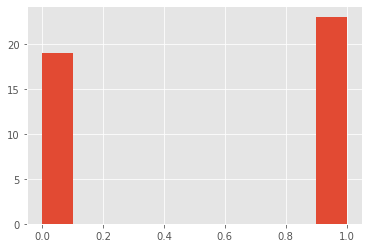

In [27]:
df_sub = pd.DataFrame.from_dict(sub_dict)
df_sub.sort_values(by='idx', inplace=True)
df_sub.Predicted.hist()

In [28]:
df_sub.to_csv('submission.csv')

In [ ]:
sub_dict = {"ID":df_test.ID.values, "Predicted": [int(df_test.iloc[i,4]>7) for i in range(len(df_test))]}
df_sub = pd.DataFrame.from_dict(sub_dict)
df_sub.head()

In [ ]:
df_sub.Predicted.hist()

<a href='./resnet18-50epochs.pth'>download</a>